In [1]:
import os
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError

import keras_tuner as kt
# import keras.backend as K

C:\anaconda3\envs\myproject\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Data preparation

In [2]:
# Read CSV
col_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv('bitcoin_price.csv', skiprows=2, names=col_names) # Already checked above 2 unnecessary rows

In [3]:
df.describe()

,Close,High,Low,Open,Volume
count,3971.000000,3971.000000,3971.000000,3971.000000,3.971000e+03
mean,23819.174933,24295.273006,23266.187200,23791.282610,2.011382e+10
std,28064.553304,28559.827770,27485.440528,28030.210764,2.147525e+10
min,178.102997,211.731003,171.509995,176.897003,5.914570e+06
25%,2329.104980,2424.464966,2265.059937,2322.225098,9.613275e+08
50%,10141.996094,10341.555664,9777.419922,10136.309570,1.616927e+10
75%,37985.552734,39225.917969,36907.476562,37900.130859,3.148331e+10
max,119995.414062,123091.609375,118959.195312,119997.445312,3.509679e+11


In [4]:
# We work on univarite data so
df_close_price = df[['Date', 'Close']]
df_close_price.head()

,Date,Close
0,Date,NaN
1,2014-09-17,457.334015
2,2014-09-18,424.440002
3,2014-09-19,394.795990
4,2014-09-20,408.903992


In [5]:
# Null values
df_close_price.isna().sum()
df_close_price.dropna(inplace=True)
df_close_price.head()

C:\Users\Koshti's PC\AppData\Local\Temp\ipykernel_6888\2805846416.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close_price.dropna(inplace=True)


,Date,Close
1,2014-09-17,457.334015
2,2014-09-18,424.440002
3,2014-09-19,394.795990
4,2014-09-20,408.903992
5,2014-09-21,398.821014


In [6]:
# Check DTYPES
df_close_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3971 entries, 1 to 3971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3971 non-null   object 
 1   Close   3971 non-null   float64
dtypes: float64(1), object(1)
memory usage: 93.1+ KB


In [7]:
df_close_price['Date'] = pd.to_datetime(df_close_price['Date'])

C:\Users\Koshti's PC\AppData\Local\Temp\ipykernel_6888\3228809802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close_price['Date'] = pd.to_datetime(df_close_price['Date'])


In [8]:
df_close_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3971 entries, 1 to 3971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3971 non-null   datetime64[ns]
 1   Close   3971 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 93.1 KB


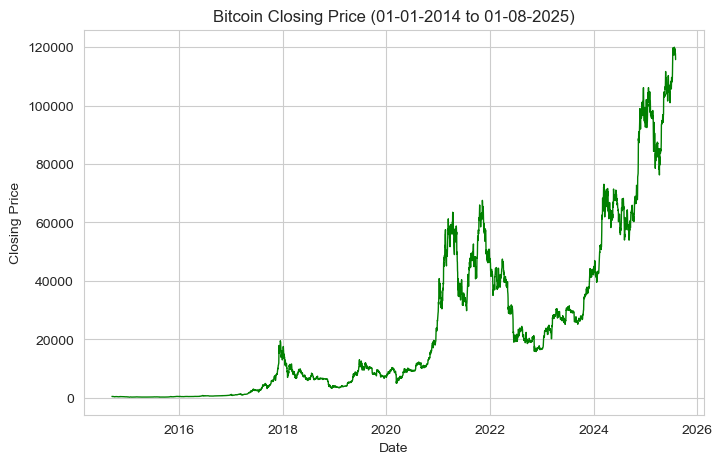

In [9]:
# Visualizing
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_close_price, x='Date', y='Close', color='green', linewidth=1)

plt.title('Bitcoin Closing Price (01-01-2014 to 01-08-2025)')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Closing Price', fontsize=10)
# plt.xticks(rotation=45)

# plt.tight_layout()
plt.show()

In [10]:
# Train Test Split
values = df_close_price['Close'].values
values

array([   457.33401489,    424.44000244,    394.79598999, ...,
       117922.1484375 , 117831.1875    , 115758.203125  ])

In [11]:
split_index = int(len(values) * 0.8)
train_vals = values[ :split_index]
test_vals = values[split_index: ]

In [12]:
# Data Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals.reshape(-1, 1))
test_scaled = scaler.transform(test_vals.reshape(-1, 1))

In [13]:
full_scaled = np.concatenate([train_scaled, test_scaled], axis=0).squeeze()
full_scaled.shape

(3971,)

In [14]:
# Creating window and horizon as we have forcasting data
HORIZON = 1
WINDOW_SIZE = 7

In [15]:
def get_labelled_windows(x, horizon):
    """
    Returning window and label of the given data
    """
    return x[:, :-horizon], x[:, -horizon: ]

In [16]:
def make_windows(x, window_size, horizon):
    """
    Converting 1D array into 2D array of sequential windows
    """

    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - window_size+horizon-1), axis=1)

    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [17]:
full_windows, full_labels = make_windows(full_scaled, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows.shape, full_labels.shape

((3964, 7), (3964, 1))

In [18]:
# 3 data from top
for i in range(3):
    print(f"Window -> {full_windows[i]}, Label -> {full_labels[i]}")

Window -> [0.00414359 0.00365546 0.00321557 0.00342492 0.0032753  0.00332473
 0.0038239 ], Label -> [0.00363714]
Window -> [0.00365546 0.00321557 0.00342492 0.0032753  0.00332473 0.0038239
 0.00363714], Label -> [0.00346454]
Window -> [0.00321557 0.00342492 0.0032753  0.00332473 0.0038239  0.00363714
 0.00346454], Label -> [0.00335845]


In [19]:
# Window and horizon Train test split
def make_train_test_split(windows, labels, test_split):
    """
    Creates Window and label train-test split
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[ :split_size]
    train_labels = labels[ :split_size]
    test_windows = windows[split_size: ]
    test_labels = labels[split_size: ]

    return train_windows, train_labels, test_windows, test_labels

In [20]:
train_windows, train_labels, test_windows, test_labels = make_train_test_split(full_windows, full_labels, test_split=0.2)
train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape

((3171, 7), (3171, 1), (793, 7), (793, 1))

### Model Training

In [21]:
def create_model_checkpoint(model_name, save_path='model_exp'):
    """
    Saving each models
    """
    return ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                          verbose=0,
                          save_best_only=True)

In [22]:
# Evaluation metrics will be RMSE
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [23]:
tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)

<RootMeanSquaredError name=root_mean_squared_error>

#### Model 1: LSTM

In [24]:
model_1 = Sequential(name='model1_LSTM')

model_1.add(Reshape((WINDOW_SIZE, 1), input_shape=(WINDOW_SIZE,)))
model_1.add(LSTM(50, activation='tanh', return_sequences=True))
model_1.add(LSTM(50, activation='tanh'))
model_1.add(Dropout(0.2))

model_1.add(Dense(HORIZON))

model_1.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

C:\anaconda3\envs\myproject\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model_1.summary()

Model: "model1_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 7, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [27]:
history = model_1.fit(train_windows, train_labels, 
                    epochs=150, 
                    batch_size=32, 
                    validation_data=(test_windows, test_labels),
                    callbacks=[early_stop, create_model_checkpoint(model_name=model_1.name + '.keras')])

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6

#### Model 2: GRU

In [28]:
model_2 = Sequential(name='model2_GRU')

model_2.add(Reshape((WINDOW_SIZE, 1), input_shape=(WINDOW_SIZE,)))
model_2.add(GRU(50, activation='tanh', return_sequences=True))
model_2.add(Dropout(0.2))

model_2.add(GRU(50, activation='tanh', return_sequences=True))
model_2.add(Dropout(0.2))

model_2.add(GRU(50, activation='tanh', return_sequences=True))
model_2.add(Dropout(0.2))

model_2.add(GRU(50, activation='tanh'))
model_2.add(Dropout(0.2))

model_2.add(Dense(HORIZON))

model_2.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

C:\anaconda3\envs\myproject\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model_2.summary()

Model: "model2_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 7, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 50)          │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 7, 50)          │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 7, 50)          │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,901 (210.55 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [31]:
history = model_2.fit(train_windows, train_labels, 
                    epochs=150, 
                    batch_size=32, 
                    validation_data=(test_windows, test_labels),
                    callbacks=[early_stop, create_model_checkpoint(model_name=model_2.name + '.keras')])

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0542
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0783
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━

### Prediction

In [32]:
model1_train = model_1.predict(train_windows)
model1_test = model_1.predict(test_windows)

model2_train = model_2.predict(train_windows)
model2_test = model_2.predict(test_windows)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [33]:
# Inverse Transformation
model1_train_unscaled = scaler.inverse_transform(model1_train)
model1_test_unscaled = scaler.inverse_transform(model1_test)

model2_train_unscaled = scaler.inverse_transform(model2_train)
model2_test_unscaled = scaler.inverse_transform(model2_test)

train_labels_unscaled = scaler.inverse_transform(train_labels)
test_labels_unscaled = scaler.inverse_transform(test_labels)

### Evaluation

In [34]:
model1_train_rmse = np.sqrt(mean_squared_error(train_labels_unscaled, model1_train_unscaled))
model1_test_rmse = np.sqrt(mean_squared_error(test_labels_unscaled, model1_test_unscaled))

model2_train_rmse = np.sqrt(mean_squared_error(train_labels_unscaled, model2_train_unscaled))
model2_test_rmse = np.sqrt(mean_squared_error(test_labels_unscaled, model2_test_unscaled))

In [35]:
print(f"Model 1: LSTM")
print(f"Train RMSE: {model1_train_rmse}")
print(f"Test RMSE: {model1_test_rmse}\n")

print(f"Model 2: GRU")
print(f"Train RMSE: {model2_train_rmse}")
print(f"Test RMSE: {model2_test_rmse}")

Model 1: LSTM
Train RMSE: 872.5832109823475
Test RMSE: 1787.711347629696

Model 2: GRU
Train RMSE: 1534.0228884289597
Test RMSE: 3653.4343714830425


In [36]:
model1_accuracy_diff = abs(model1_train_rmse - model1_test_rmse)
model2_accuracy_diff = abs(model2_train_rmse - model2_test_rmse)

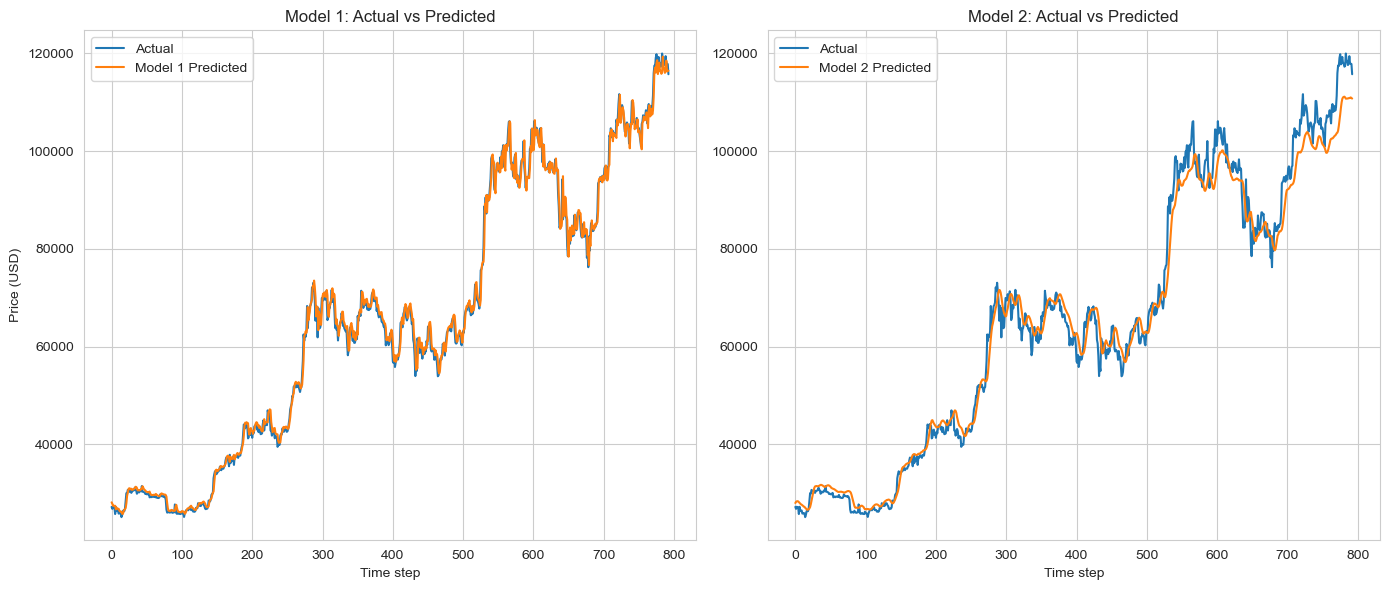

In [37]:
plt.figure(figsize=(14, 6))

# Plot for Model 1
plt.subplot(1, 2, 1)
plt.plot(test_labels_unscaled, label="Actual")
plt.plot(model1_test_unscaled, label="Model 1 Predicted")
plt.title("Model 1: Actual vs Predicted")
plt.xlabel("Time step")
plt.ylabel("Price (USD)")
plt.legend()

# Plot for Model 2
plt.subplot(1, 2, 2)
plt.plot(test_labels_unscaled, label="Actual")
plt.plot(model2_test_unscaled, label="Model 2 Predicted")
plt.title("Model 2: Actual vs Predicted")
plt.xlabel("Time step")
plt.legend()

plt.tight_layout()
plt.show()

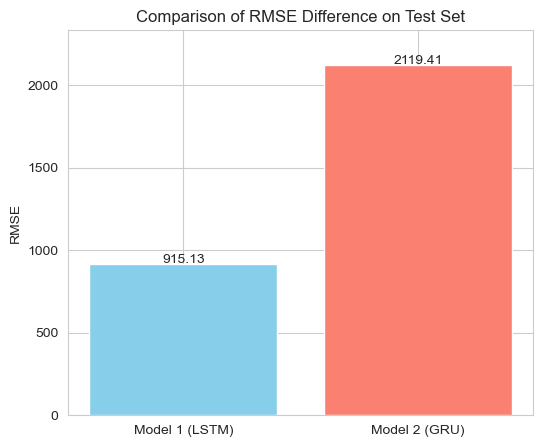

In [38]:
# RMSE values
rmse_values = [model1_accuracy_diff, model2_accuracy_diff]
model_names = ['Model 1 (LSTM)', 'Model 2 (GRU)']

# Plotting
plt.figure(figsize=(6, 5))
plt.bar(model_names, rmse_values, color=['skyblue', 'salmon'])
plt.title("Comparison of RMSE Difference on Test Set")
plt.ylabel("RMSE")
plt.ylim(0, max(rmse_values) * 1.1)  # Add some headroom
for i, val in enumerate(rmse_values):
    plt.text(i, val + 10, f"{val:.2f}", ha='center')  # Display RMSE values on top

plt.show()